# INCEPTION块

GoogLeNet中的基础卷积块叫作Inception块，得名于同名电影《盗梦空间》（Inception）。与NiN块相⽐，这个基础块在结构上更加复杂。

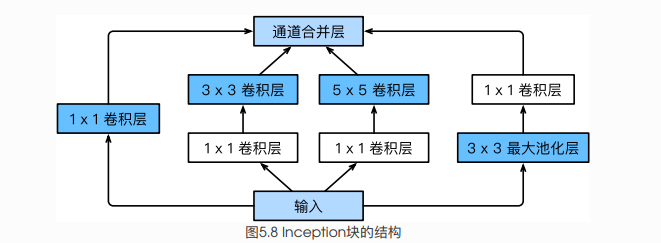

由图5.8可以看出，Inception块⾥有4条并⾏的线路。前3条线路使⽤窗⼝⼤⼩分别是1x1 、3x3 和5x5的卷积层来抽取不同空间尺⼨下的信息，其中中间2个线路会对输⼊先做 1x1卷积来减少输⼊通道数，以降低模型复杂度。第四条线路则使⽤3x3 最⼤池化层，后接1x1 卷积层来改变通道数。4条线路都使⽤了合适的填充来使输⼊与输出的⾼和宽⼀致。最后我们将每条线路的输出在通道维上连结，并输⼊接下来的层中去。

In [1]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F
import sys
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Inception(nn.Module):
    #c1-c4为每条线路里的层的输出通道数
    def __init__(self,in_c,c1,c2,c3,c4):
        super(Inception,self).__init__()
        #线路1，单1x1卷积层
        self.p1_1=nn.Conv2d(in_c,c1,kernel_size=1)
        #线路2，1x1卷积层后接3x3卷积层
        self.p2_1=nn.Conv2d(in_c,c2[0],kernel_size=1)
        self.p2_2=nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        #线路3，1x1卷积层后接5x5卷积层
        self.p3_1=nn.Conv2d(in_c,c3[0],kernel_size=1)
        self.p3_2=nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
        #线路4，3x3最大池化层后接1x1卷积层
        self.p4_1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2=nn.Conv2d(in_c,c4,kernel_size=1)
    def forward(self,x):
        p1=F.relu(self.p1_1(x))
        p2=F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3=F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4=F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1,p2,p3,p4),dim=1)#在通道维上连结输出

# GOOGLENET模型

GoogLeNet跟VGG⼀样，在主体卷积部分中使⽤5个模块（block），每个模块之间使⽤步幅为2的3x3最⼤池化层来减⼩输出⾼宽。第⼀模块使⽤⼀个64通道的 7x7卷积层。

In [3]:
b1=nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

第⼆模块使⽤2个卷积层：⾸先是64通道的1x1 卷积层，然后是将通道增⼤3倍的3x3 卷积层。它对应Inception块中的第⼆条线路。

In [12]:
b2=nn.Sequential(nn.Conv2d(64,64,kernel_size=1),
                nn.Conv2d(64,192,kernel_size=3,padding=1),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

第三模块串联 2 个完整的 Inception 块。第⼀个 Inception 块的输出通道数为64+128+32+32=256，其中4条线路的输出通道数⽐例为 64:128:32:32=2:4:1:1。其中第⼆、第三条线路先分别将输⼊通道数减⼩⾄96/192=1/2 和16/192=1/12 后，再接上第⼆层卷积层。第⼆个Inception块输出通道数增⾄128+192+96+64=480 ，每条线路的输出通道数之⽐ 为128:192:96:64=4:6:3:2 。 其 中 第 ⼆ 、 第 三 条 线 路 先 分 别 将 输 ⼊ 通 道 数 减 ⼩ ⾄128/256=1/2和32/256=1/8 。

In [13]:
b3=nn.Sequential(Inception(192,64,(96,128),(16,32),32),
                Inception(256,128,(128,192),(32,96),64),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

第四模块更加复杂。它串联了5个Inception块，其输出通道数分别是192+208+48+64=512 、160+224+64+64=512 、128+256+64+64=512 、112+288+64+64=528 和256+320+128+128=832 。这些线路的通道数分配和第三模块中的类似，⾸先含 3x3卷积层的第⼆条线路输出最多通道，其次是仅含 1x1卷积层的第⼀条线路，之后是含5x5 卷积层的第三条线路和含3x3 最⼤池化层的第四条线路。其中第⼆、第三条线路都会先按⽐例减⼩通道数。这些⽐例在各个Inception块中都略有不同。

In [14]:
b4=nn.Sequential(Inception(480,192,(96,208),(16,48),64),
                Inception(512,160,(112,224),(24,64),64),
                Inception(512,128,(128,256),(24,64),64),
                Inception(512,112,(144,288),(32,64),64),
                Inception(528,256,(160,320),(32,128),128),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

第五模块有输出通道数为256+320+128+128=832 和384+384+128+128=1024 的两个Inception块。其中每条线路的通道数的分配思路和第三、第四模块中的⼀致，只是在具体数值上有所不同。需要注意的是，第五模块的后⾯紧跟输出层，该模块同NiN⼀样使⽤全局平均池化层来将每个通道的⾼和宽变成1。最后我们将输出变成⼆维数组后接上⼀个输出个数为标签类别数的全连接层。

In [15]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d,self).__init__()
    def forward(self,x):
        return F.avg_pool2d(x,kernel_size=x.size()[2:])

In [16]:
b5=nn.Sequential(Inception(832,256,(160,320),(32,128),128),
                Inception(832,384,(192,384),(48,128),128),
                 GlobalAvgPool2d())

In [ ]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

In [17]:
net=nn.Sequential(b1,b2,b3,b4,b5,FlattenLayer(),nn.Linear(1024,10))
X=torch.rand(1,1,96,96)
for blk in net.children():
    X=blk(X)
    print('output shape:',X.shape)

output shape: torch.Size([1, 64, 24, 24])
output shape: torch.Size([1, 192, 12, 12])
output shape: torch.Size([1, 480, 6, 6])
output shape: torch.Size([1, 832, 3, 3])
output shape: torch.Size([1, 1024, 1, 1])
output shape: torch.Size([1, 1024])
output shape: torch.Size([1, 10])


# 获取数据和训练模型

In [18]:
import torchvision
import torchvision.transforms as transforms
def load_data_fashion_mnist(batch_size,resize=None,root='./Datasets/FashionMNIST'):
    trans=[]
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform=torchvision.transforms.Compose(trans)
    mnist_train=torchvision.datasets.FashionMNIST(root=root,train=True,download=True,transform=transform)
    mnist_test=torchvision.datasets.FashionMNIST(root=root,train=False,download=True,transform=transform)
    train_iter=torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=0)
    test_iter=torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=0)
    return train_iter,test_iter

batch_size=128
train_iter,test_iter=load_data_fashion_mnist(batch_size,resize=96)
lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)

In [19]:
def evaluate_accuracy(data_iter,net,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum,n=0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(net,torch.nn.Module):
                net.eval()#评估模式，这会关闭dropout
                acc_sum+=(net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
                net.train()#改回训练模式
            else:
                if('is_training' in net.__code__.co_varname):
                    acc_sum+=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
    return acc_sum/n

def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs):
    net=net.to(device)
    print('training on ',device)
    loss=torch.nn.CrossEntropyLoss()
    batch_count=0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y in train_iter:
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.cpu().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        test_acc=evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f,time %.lf sec'%(epoch+1,train_l_sum/batch_count,train_acc_sum/n,test_acc,time.time()-start))
        

In [20]:
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on  cuda
epoch 1,loss 0.9760,train acc 0.629,test acc 0.820,time 679 sec
epoch 2,loss 0.2095,train acc 0.847,test acc 0.864,time 678 sec
epoch 3,loss 0.1138,train acc 0.873,test acc 0.874,time 678 sec
epoch 4,loss 0.0742,train acc 0.890,test acc 0.889,time 678 sec
epoch 5,loss 0.0551,train acc 0.899,test acc 0.892,time 678 sec
